In [15]:
# import libraries 

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pymc3 as pm
import arviz as az

sns.set_theme()

plt.rcParams['figure.figsize'] = [10, 8]

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
###################################

import fluospec

# 2. Generative model:
Theory describes that in the absence of external broadening mechanisms,  the intensity profile of the fluorescence of atoms and molecules is given by a Lorentzian line shape:
$$ I(\omega) = A \frac{\Gamma^2/4}{(\omega - \omega_0)^2 + \Gamma^2/4}$$
where $A$ is the amplitude, $\omega_0$ is the center frequency of the fluorescence and $\Gamma$ is the decay rate of the transition (also the full width at half maximum).

In our data, we have a background that is linear with the frequency which can be modeled by a linear equation:
$$ I_b(\omega) = m\omega + b$$
such that the full model is 
$$I_T(\omega) = I(\omega) + I_b(\omega) = A \frac{\Gamma^2/4}{(\omega - \omega_0)^2 + \Gamma^2/4} + (m\omega + b)$$

Noise on the camera is fairly complex, but data points are averaged, so that the noise on the camera can be characterized as Gaussian with $\sigma$ = 0.2, thus:
$$ y_i \sim \text{normal}(\mu_i = I_T(\omega_i) ,\sigma_i = 0.2)$$

Lastly the priors for all our parameters will be uniform: 
$$A \sim \text{uniform}(0,5)$$

$$\omega_0 \sim \text{uniform}(10,30)$$

$$\Gamma \sim \text{uniform}(0,10)$$

$$m \sim \text{uniform}(0,0.1)$$

$$b \sim \text{uniform}(0,3)$$

Thus the full statistical model is:
$$ \boxed{y_i \sim \text{normal}(\mu_i = I_T(\omega_i) ,\sigma_i = 0.2)\\A \sim \text{uniform}(0,5) \\\omega_0 \sim \text{uniform}(10,30)\\\Gamma \sim \text{uniform}(0,10)\\m \sim \text{uniform}(0,0.1)\\b \sim \text{uniform}(0,3)}$$



# 3. Simulatation of data:
We begin by defining a function for our Lorentzian line shape:

In [39]:
def Lorentzian(w: np.ndarray,
               A: float,
               w0: float,
               gamma: float
     ) -> np.ndarray: 
    """
    Calculates the Lorentzian line shape 
    
    Parameters:
    -----------
    A : float
        Amplitude of line 
    w : ndarray
        Frequency
    w0 : ndarray
        Central frequency
    gamma : ndarray
        The decay rate of the transition. 
        Also the full width at half maximum      
    Returns
    -------
    ndarray:
        array of the Lorentianz of the parameters  
    """
        
    lorentzian = A*(gamma**2/4)/((w - w0)**2 + (gamma**2/4))
    return lorentzian 

In [54]:
# Define our
w_sim = np.linspace(0,40,250)
w0_sim = 20
A_sim = 1
gamma_sim = 5

m_sim = .05
b_sim = 2

uncertainty = .2

foreground = Lorentzian(w_sim, A_sim, w0_sim, gamma_sim)

noise = np.random.normal(0, uncertainty, len(w_sim))
background = noise + (m_sim*w_sim + b_sim)

sim_data = (foreground + background)

In [45]:
# define the data 
data = pd.DataFrame({'w': w_sim,
                     'I': sim_data,
                     'sigma_I': uncertainty})
w = data.w
I = data.I
sigma_I = data.sigma_I

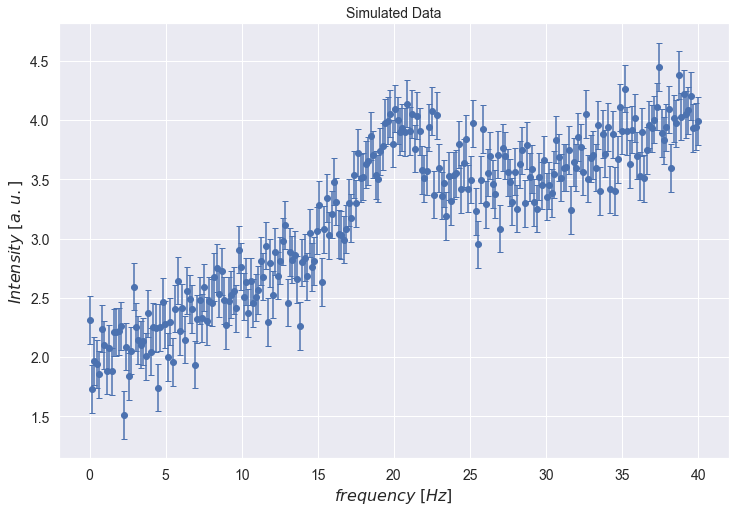

In [55]:
# data.plot(x='w', y='I', kind='scatter', yerr=uncertainty);
plt.figure(figsize=(12,8))
plt.errorbar(w, I, yerr=sigma_I, fmt='o', capsize=3)
plt.xlabel('$frequency \ [Hz]$')
plt.ylabel('$Intensity \ [a.u.]$')
plt.title('Simulated Data');

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, m, gamma, w0, A]


Sampling 4 chains for 5_000 tune and 2_000 draw iterations (20_000 + 8_000 draws total) took 22 seconds.
The acceptance probability does not match the target. It is 0.6313158473751866, but should be close to 0.8. Try to increase the number of tuning steps.


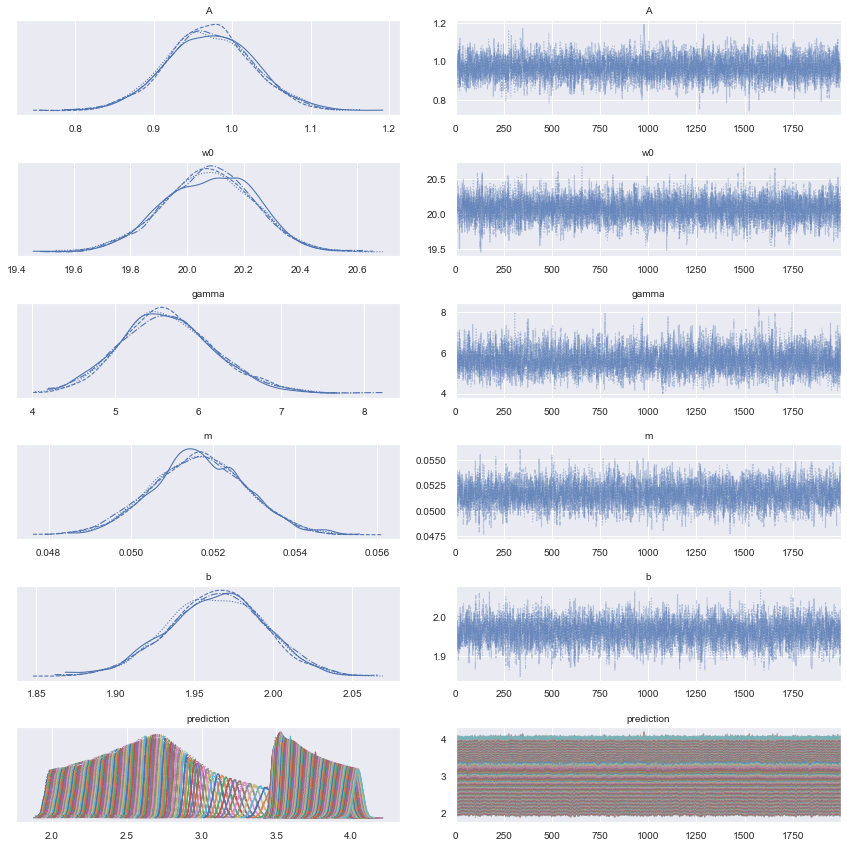

In [46]:
spectroscopy_model = pm.Model()

w = np.array(w)

with spectroscopy_model:
    A = pm.Uniform('A', 0, 5)
    w0 = pm.Uniform('w0', 10, 30)
    gamma = pm.Uniform('gamma', 0, 10)
    
    m = pm.Uniform('m', 0, 0.1)
    b = pm.Uniform('b', 0, 3)
    
    peak = Lorentzian(w, A, w0, gamma)
    line = m*w + b
        
    I_pred = pm.Deterministic('prediction', line + peak)
 
    measurements = pm.Normal('I_model', mu=I_pred, sigma=uncertainty, observed=I)

    trace = pm.sample(start=pm.find_MAP(), return_inferencedata=True, tune=5000, draws=2000)
    az.plot_trace(trace)
    plt.tight_layout()

posterior = trace.posterior.to_dataframe()

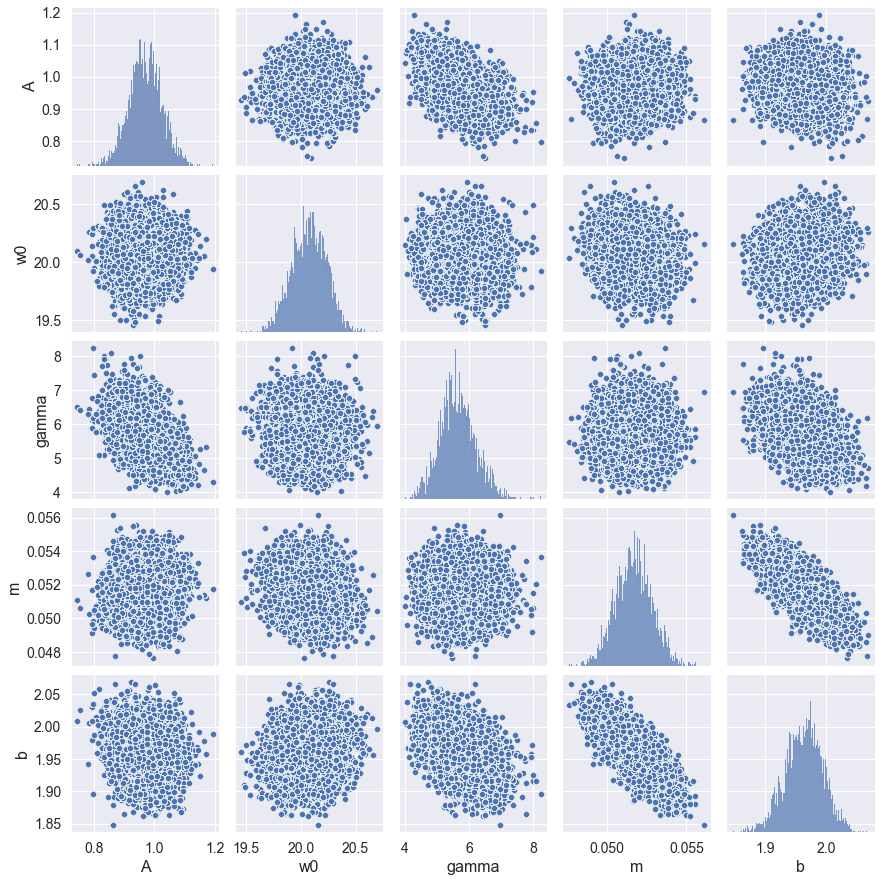

In [47]:
sns.pairplot(posterior.drop('prediction', axis=1))

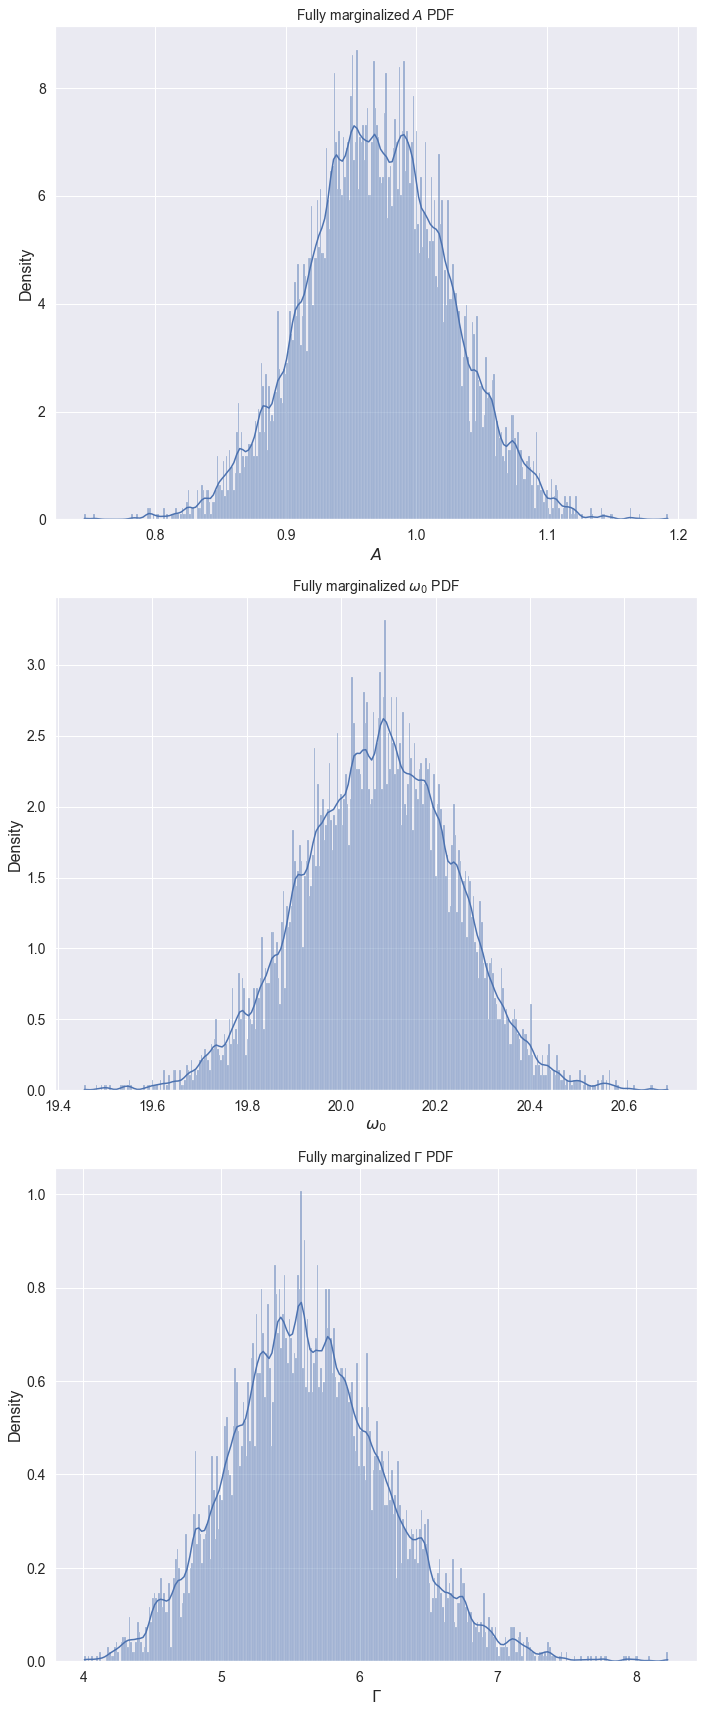

In [69]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(10, 24))

marg_A = sns.histplot(posterior.A,
                      fill=True, stat="density",
                      kde=True,
                      ax=ax1
                     )
marg_A.set(xlabel='$A$',
                   title='Fully marginalized $A$ PDF'
                  );


marg_w0 = sns.histplot(posterior.w0,
                       fill=True, stat="density",
                       kde=True,
                       ax=ax2
                      )
marg_w0.set(xlabel='$\omega_0$',
                   title='Fully marginalized $\omega_0$ PDF'
                  );

marg_gamma = sns.histplot(posterior.gamma,
                          fill=True, stat="density",
                          kde=True,
                          ax=ax3
                         )
marg_gamma.set(xlabel='$\Gamma$',
                   title='Fully marginalized $\Gamma$ PDF'
                  );

plt.tight_layout()


In [65]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
A,0.971,0.055,0.867,1.075,0.001,0.001,5026.0,3305.0,1.0
w0,20.077,0.161,19.769,20.371,0.002,0.001,5867.0,4879.0,1.0
gamma,5.639,0.575,4.514,6.686,0.009,0.006,4509.0,3347.0,1.0
m,0.052,0.001,0.050,0.054,0.000,0.000,4333.0,3842.0,1.0
b,1.964,0.031,1.908,2.024,0.000,0.000,4099.0,4223.0,1.0
...,...,...,...,...,...,...,...,...,...
prediction[245],4.018,0.028,3.967,4.071,0.000,0.000,5615.0,4713.0,1.0
prediction[246],4.026,0.028,3.974,4.079,0.000,0.000,5610.0,4713.0,1.0
prediction[247],4.034,0.028,3.981,4.087,0.000,0.000,5605.0,4742.0,1.0
prediction[248],4.042,0.028,3.989,4.095,0.000,0.000,5600.0,4742.0,1.0
